In [1]:
import pandas as pd
import numpy as np

from starknet_py.net.account.account import Account
from starknet_py.net.full_node_client import FullNodeClient
from starknet_py.net.models.chains import StarknetChainId
from starknet_py.net.signer.key_pair import KeyPair
from starknet_py.net.signer.stark_curve_signer import StarkCurveSigner
from starknet_py.contract import Contract

from cauchy_simulations import CauchyLiquidityProfile, ModifiedCauchyLiquidityProfile, from_bps_tick

In [2]:
client = FullNodeClient(node_url="https://rpc.starknet.lava.build:443")

In [3]:
account = Account(
    client=client,
    address="0x4321",
    key_pair=KeyPair(private_key=654, public_key=321),
    chain=StarknetChainId.MAINNET,
)

In [4]:
LP_ADDRESS = "0x02253efb6547890843ed4e3d315d40307660ecb72e7364667c90700ecffae490"
CORE_ADDRESS = "0x5dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b"
PROFILE_ADDRESS = "0x510584005169c065c9ff729e93989c84a50e8ee1037a8a368a332145d0ad646"

In [6]:
lp_contract = await Contract.from_address(address=LP_ADDRESS, provider=account)

In [7]:
lp_contract.functions.keys()

dict_keys(['get_primary_interface_id', 'create_and_initialize_pool', 'compound_fees', 'add_liquidity', 'remove_liquidity', 'core', 'profile', 'pool_token', 'pool_liquidity_factor', 'pool_reserves', 'pool_minimum_liquidity_factor', 'locked', 'before_initialize_pool', 'after_initialize_pool', 'before_swap', 'after_swap', 'before_update_position', 'after_update_position', 'before_collect_fees', 'after_collect_fees', 'get_owner', 'transfer_ownership', 'replace_class_hash', 'sweep'])

In [8]:
await lp_contract.functions['core'].call()

(OrderedDict([('contract_address',
               158098919692956613592021320609952044916245725306097615271255138786123)]),)

In [9]:
await lp_contract.functions['profile'].call()

(OrderedDict([('contract_address',
               2290442875603752814070917145208699944902623559823440137512872934644430591558)]),)

In [10]:
# WBTC/WWBTC 1bps fee, 0.01bps spacing pool
pool_key = {
    "token0": 0x03fe2b97c1fd336e750087d68b9b867997fd64a2661ff3ca5a7c771641e8e7ac, # token0
    "token1": 0x0577bddfccc35c714e99638d4f03ee6bc51e38895c7abc4df1b1e1ab4854b2ce, # token1
    "fee": 34028236692093846346337460743176821, # fee
    "tick_spacing": 1, # tick spacing
    "extension": 0x02253efb6547890843ed4e3d315d40307660ecb72e7364667c90700ecffae490, # extension
}

In [11]:
await lp_contract.functions['pool_reserves'].call(pool_key)

((11589, 12206),)

In [12]:
core_contract = await Contract.from_address(address=CORE_ADDRESS, provider=account)

In [13]:
core_contract.functions.keys()

dict_keys(['get_primary_interface_id', 'get_protocol_fees_collected', 'get_locker_state', 'get_locker_delta', 'get_pool_price', 'get_pool_liquidity', 'get_pool_fees_per_liquidity', 'get_pool_fees_per_liquidity_inside', 'get_pool_tick_liquidity_delta', 'get_pool_tick_liquidity_net', 'get_pool_tick_fees_outside', 'get_position', 'get_position_with_fees', 'get_saved_balance', 'next_initialized_tick', 'prev_initialized_tick', 'withdraw_all_protocol_fees', 'withdraw_protocol_fees', 'lock', 'forward', 'withdraw', 'save', 'pay', 'load', 'initialize_pool', 'maybe_initialize_pool', 'update_position', 'collect_fees', 'swap', 'accumulate_as_fees', 'set_call_points', 'get_call_points', 'get_owner', 'transfer_ownership', 'replace_class_hash'])

In [14]:
profile_contract = await Contract.from_address(address=PROFILE_ADDRESS, provider=account)

In [15]:
profile_contract.functions.keys()

dict_keys(['initial_liquidity_factor', 'description', 'set_liquidity_profile', 'get_liquidity_profile', 'get_liquidity_updates', 'get_bounds_for_liquidity_updates'])

In [16]:
ZERO_I129 = {
    "mag": 0,
    "sign": False,
}

In [17]:
(liquidity_update_params,) = await profile_contract.functions['get_liquidity_updates'].call(pool_key, ZERO_I129)

In [18]:
data = {'tick': [], 'liquidity_delta': []}

In [19]:
def i129_to_int(i: dict) -> int:
    return -i['mag'] if i['sign'] else i['mag']

In [20]:
for params in liquidity_update_params:
    tick_lower = i129_to_int(params['bounds']['lower'])
    tick_upper = i129_to_int(params['bounds']['upper'])
    data['tick'].extend([tick_lower, tick_upper])
    print(f"tick range: {(tick_lower, tick_upper)}")

    (result_liquidity_delta_lower, ) = await core_contract.functions["get_pool_tick_liquidity_delta"].call(pool_key, params['bounds']['lower'])
    (result_liquidity_delta_upper, ) = await core_contract.functions["get_pool_tick_liquidity_delta"].call(pool_key, params['bounds']['upper'])
    liquidity_delta_lower = i129_to_int(result_liquidity_delta_lower)
    liquidity_delta_upper = i129_to_int(result_liquidity_delta_upper)
    data['liquidity_delta'].extend([liquidity_delta_lower, liquidity_delta_upper])
    print(f"liq delta lower: {liquidity_delta_lower}")
    print(f"liq delta upper: {liquidity_delta_upper}")

tick range: (-88722883, 88722883)
liq delta lower: 5040
liq delta upper: -5040
tick range: (-16000, 16001)
liq delta lower: 79510
liq delta upper: -79510
tick range: (-14000, 14001)
liq delta lower: 23853
liq delta upper: -23853
tick range: (-12000, 12001)
liq delta lower: 36318
liq delta upper: -36318
tick range: (-10000, 10001)
liq delta lower: 59097
liq delta upper: -59097
tick range: (-8000, 8001)
liq delta lower: 105237
liq delta upper: -105237
tick range: (-7000, 7001)
liq delta lower: 86042
liq delta upper: -86042
tick range: (-6000, 6001)
liq delta lower: 126768
liq delta upper: -126768
tick range: (-5000, 5001)
liq delta lower: 196040
liq delta upper: -196040
tick range: (-4000, 4001)
liq delta lower: 320789
liq delta upper: -320789
tick range: (-3500, 3501)
liq delta lower: 238534
liq delta upper: -238534
tick range: (-3000, 3001)
liq delta lower: 318048
liq delta upper: -318048
tick range: (-2500, 2501)
liq delta lower: 426648
liq delta upper: -426648
tick range: (-2000, 200

In [68]:
df = pd.DataFrame(data=data)
df = df.sort_values(by='tick')

In [69]:
df['liquidity'] = df['liquidity_delta'].cumsum()

In [70]:
df

,tick,liquidity_delta,liquidity
0,-88722883,5040,5040
2,-16000,79510,84550
4,-14000,23853,108403
6,-12000,36318,144721
8,-10000,59097,203818
10,-8000,105237,309055
12,-7000,86042,395097
14,-6000,126768,521865
16,-5000,196040,717905
18,-4000,320789,1038694


In [71]:
TICK_MIN_LIMIT = -100000
TICK_STEP = 10

In [72]:
ticks = np.arange(TICK_MIN_LIMIT, -TICK_MIN_LIMIT + 1, TICK_STEP)
data_cleaned = {'tick': list(ticks), 'liquidity': []}

In [73]:
for tick in ticks:
    liquidity = df[df['tick'] <= tick]['liquidity_delta'].sum()
    data_cleaned['liquidity'].extend([liquidity])

In [74]:
df_cleaned = pd.DataFrame(data=data_cleaned)

In [75]:
df_cleaned

,tick,liquidity
0,-100000,5040
1,-99990,5040
2,-99980,5040
3,-99970,5040
4,-99960,5040
...,...,...
19996,99960,5040
19997,99970,5040
19998,99980,5040
19999,99990,5040


<Axes: xlabel='tick'>

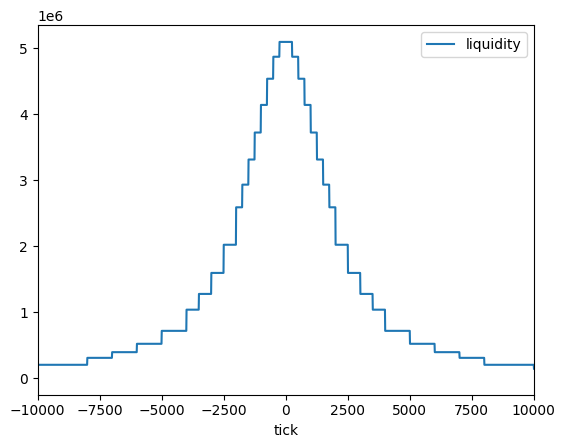

In [76]:
df_cleaned.plot(x='tick', y='liquidity', xlim=(-10000, 10000))

<Axes: xlabel='tick'>

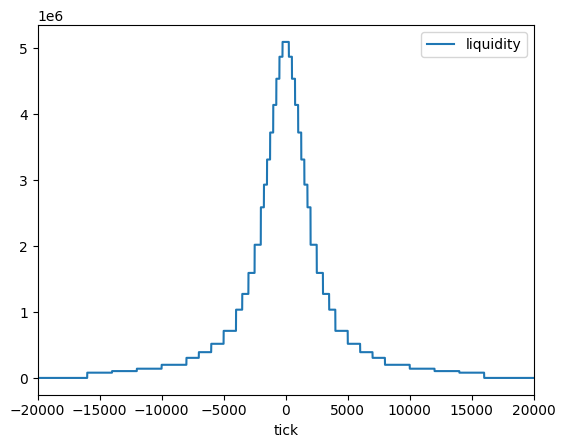

In [77]:
df_cleaned.plot(x='tick', y='liquidity', xlim=(-20000, 20000))

In [78]:
# normalize by pool liquidity factor
(lf, ) = await lp_contract.functions['pool_liquidity_factor'].call(pool_key)
lf

32473224044

In [79]:
GAMMA = 2000
PEG = 64000
mclp = ModifiedCauchyLiquidityProfile(c=lf, gamma=GAMMA, peg=PEG)

In [80]:
df_cleaned['model'] = mclp.at(df_cleaned['tick'])

In [81]:
# ya so wanna change profile to be bounds of (-x, x + tick_spacing) for each x adding liq to
# given poolState.liquidity is sum of liquidity delta from
# t >= min_tick to t <= poolState.tick (inclusive of liq delta value on positive side)
# which is tilting are current setup slightly
# with new bounds negative liquidity delta less on positive side bound wont get added in until
# after next tick spacing 
df_cleaned

,tick,liquidity,model
0,-100000,5040,7108.701715
1,-99990,5040,7109.114908
2,-99980,5040,7109.528225
3,-99970,5040,7109.941667
4,-99960,5040,7110.355232
...,...,...,...
19996,99960,5040,7110.355232
19997,99970,5040,7109.941667
19998,99980,5040,7109.528225
19999,99990,5040,7109.114908


<Axes: xlabel='tick'>

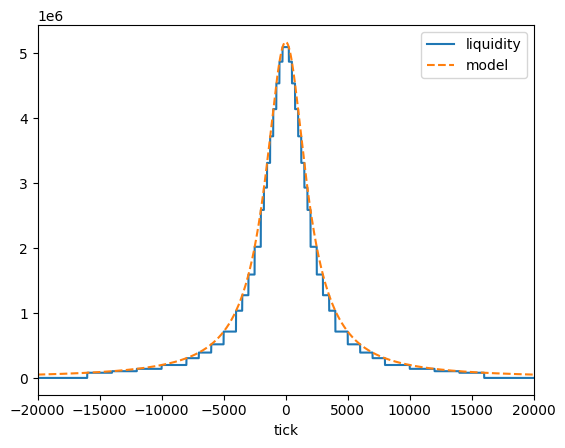

In [84]:
df_cleaned.plot(x='tick', y=['liquidity', 'model'], xlim=(-20000, 20000), style=['-', '--'])

<Axes: xlabel='tick'>

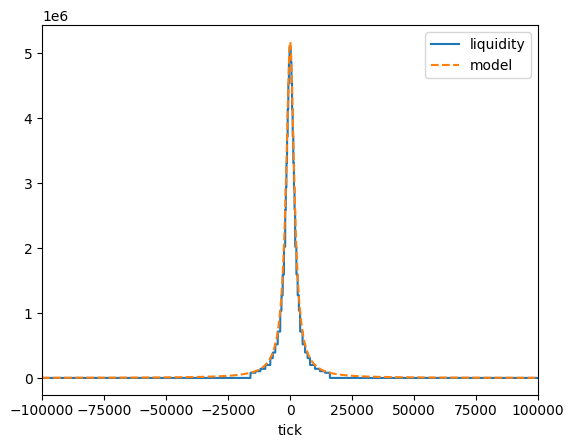

In [85]:
df_cleaned.plot(x='tick', y=['liquidity', 'model'], xlim=(-100000, 100000), style=['-', '--'])